# TinyStories in TransformerLens  (Decomposing TinyStories with Dictionary Learning)

## Utility Functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_activation(mlp_out, width=30, height=10, plot_range=False):
    # Convert the tensor to a numpy array
    mlp_out_np = mlp_out.detach().cpu() # .numpy()
    clipped_mlp_out_np = mlp_out_np.clip(min=-3, max=100)

    # Create a heatmap with larger figure size
    fig, ax = plt.subplots(figsize=(width, height))

    cax = ax.imshow(mlp_out_np, cmap='viridis', vmin=0, vmax=1)  # Set vmin and vmax for color scale

    # Adjust colorbar size and position
    if plot_range:
        cbar = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Activation Value')

    plt.xlabel('Feature Dimension')
    plt.ylabel('Token Index')
    plt.title('MLP Layer Outputs')
    plt.show()

In [2]:
import torch

def get_stats(mlp_out):
    # Compute statistics
    mean_val = torch.mean(mlp_out)
    std_val = torch.std(mlp_out)
    max_val = torch.max(mlp_out)
    min_val = torch.min(mlp_out)
    
    # Compute quartiles
    q25 = torch.quantile(mlp_out, 0.25)
    median = torch.quantile(mlp_out, 0.50)
    q75 = torch.quantile(mlp_out, 0.75)

    # Display the results
    print(f"Mean: {mean_val.item():.4f}")
    print(f"Standard Deviation: {std_val.item():.4f}")
    print(f"Max Value: {max_val.item():.4f}")
    print(f"Min Value: {min_val.item():.4f}")
    print(f"1st Quartile (25th Percentile): {q25.item():.4f}")
    print(f"Median (50th Percentile): {median.item():.4f}")
    print(f"3rd Quartile (75th Percentile): {q75.item():.4f}")

## Tiny Stories Model

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

current_model = "roneneldan/TinyStories-1Layer-21M"

model     = AutoModelForCausalLM.from_pretrained(current_model)
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
prompt    = """one""" # """One day, Lucy asks Tom: "I am looking for a banana but I can't find it". Tom says: "Don't"""
input_ids = tokenizer.encode(prompt, return_tensors="pt")
output    = model.generate(input_ids, max_length = 1, num_beams=1)
output_text = tokenizer.decode(output[0], skip_special_tokens=True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


## Hooked Transformer

In [5]:
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
model = HookedTransformer.from_pretrained(
    current_model,
    hf_model=model,
    device="cpu",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer)

Using pad_token, but it is not set yet.


Loaded pretrained model roneneldan/TinyStories-1Layer-21M into HookedTransformer


## MLP Activations and Logits

In [6]:
def process_list(lst):
    logits = []
    cache  = []
    for txt in lst:
        tinystories_text   = txt
        tinystories_tokens = model.to_tokens(
            tinystories_text,
            prepend_bos=False)
        tinystories_logits, tinystories_cache = \
            model.run_with_cache(
                tinystories_tokens,
                remove_batch_dim=True)
        logits.append(tinystories_logits)                           # post linear proj logits
        cache.append(tinystories_cache["ln_final.hook_normalized"]) # final embedding
    return logits, cache

def batch_process_list(lst):
    tinystories_tokens = [model.to_tokens(txt, prepend_bos=False)
                          for txt in lst]
    tinystories_tokens = torch.tensor(tinystories_tokens).unsqueeze(1)
    print("tinystories_tokens.shape:", tinystories_tokens.shape, tinystories_tokens)
    tinystories_logits, tinystories_cache = \
        model.run_with_cache(
            tinystories_tokens,
            remove_batch_dim=False)
    # print("tinystories_cache", tinystories_cache)
    return tinystories_logits, tinystories_cache["ln_final.hook_normalized"]

input_list = [chr(i) for i in range(ord('a'), ord('z')+1)] # letters a-z (will eventually be replaced with tiny stories entire dataset)
batch_logits_s, batch_cache_s = batch_process_list(input_list)

print(
    "logits:\n", batch_logits_s.shape,
    "\ncache:\n", batch_cache_s.shape)

tinystories_tokens.shape: torch.Size([26, 1]) tensor([[64],
        [65],
        [66],
        [67],
        [68],
        [69],
        [70],
        [71],
        [72],
        [73],
        [74],
        [75],
        [76],
        [77],
        [78],
        [79],
        [80],
        [81],
        [82],
        [83],
        [84],
        [85],
        [86],
        [87],
        [88],
        [89]])
logits:
 torch.Size([26, 1, 50257]) 
cache:
 torch.Size([26, 1, 1024])


## Sparse Autoencoder

### Model

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class SparseAutoencoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(SparseAutoencoder, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        x = self.fc2(h)
        return h, x

### Training

#### Train

In [ ]:
from einops import rearrange, repeat

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from tqdm.notebook import tqdm
import torch.optim as optim

MAX_LR = 1e-3
EPOCHS = 500

feature_scaling = 1.0

# in := d_model, hidden := d_model * feature_scaling, out := d_model
autoencoder = SparseAutoencoder(
    in_dim=model.cfg.d_model,
    hidden_dim=int(model.cfg.d_model * feature_scaling),
    out_dim=model.cfg.d_model).to(device)

optimizer = optim.Adam(
    autoencoder.parameters(),
    lr=MAX_LR)

criterion = nn.MSELoss()

# L1 regularization coefficient
l1_coeff = 1e-5

activations = batch_cache_s.to(device)

for e in range(EPOCHS):
    # for i, activations in enumerate(batch_cache_s):
    
    # Compute forward pass, capturing hidden layer activations
    hidden_activations, reconstructions = autoencoder(activations)
    
    # Compute the MSE loss
    reconstruction_loss = criterion(reconstructions, activations)
    
    # Compute the L1 loss of the hidden layer activations
    l1_loss = hidden_activations.abs().sum()
    
    # Combine the losses
    loss = reconstruction_loss + (l1_coeff * l1_loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 10 == 0:
        print("LOSS:", e, loss.item())

#### Test

In [10]:
act_idx = 0

activations = batch_cache_s # [act_idx]
activations = activations.to(device)
hidden_activation, reconstruction = autoencoder(activations)

In [11]:
hidden_activation.shape

torch.Size([26, 1, 1024])

In [12]:
# sparsity = (hidden_activation == 0).sum().item() / hidden_activation.shape[1]
# (hidden_activation == 0).sum().item(), hidden_activation.shape[0], f"{sparsity * 100:.2f}% sparsity"

num_zeros = (hidden_activation == 0).sum().item()
total_elements = hidden_activation.numel()
sparsity = num_zeros / total_elements
f"{sparsity * 100:.10f}% sparsity"

'99.4290865385% sparsity'

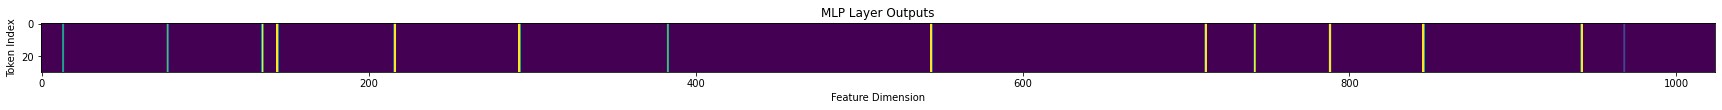

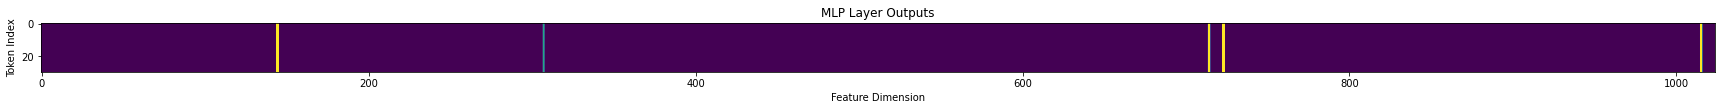

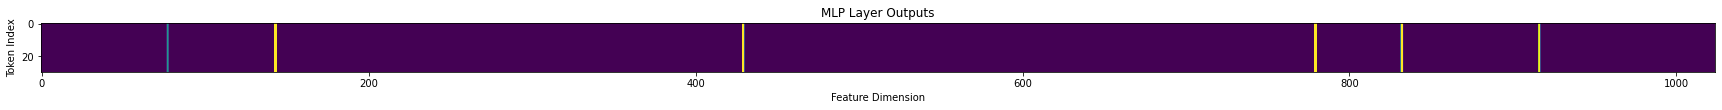

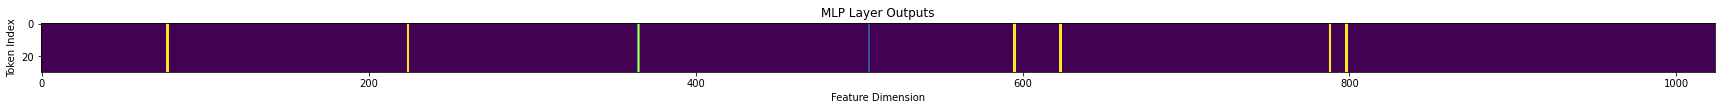

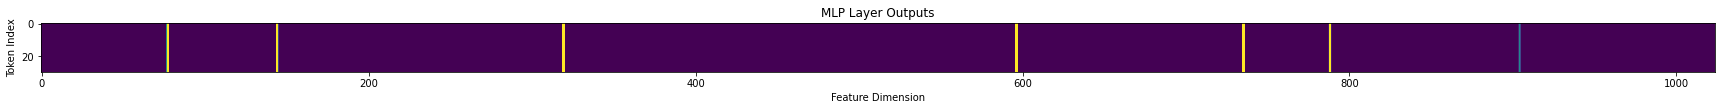

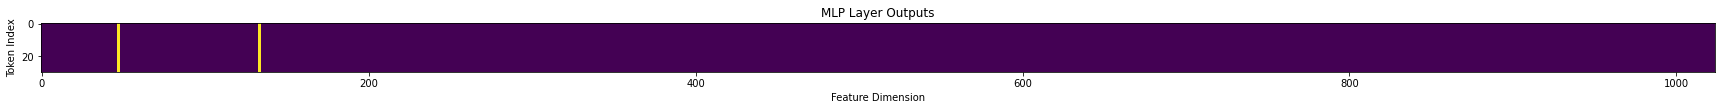

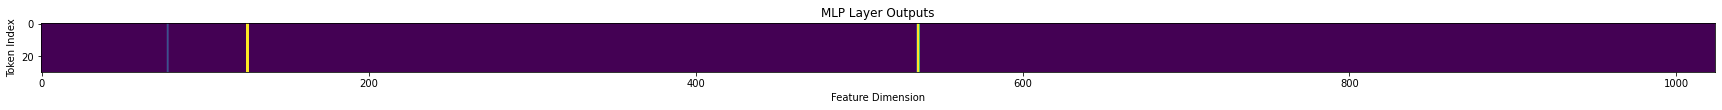

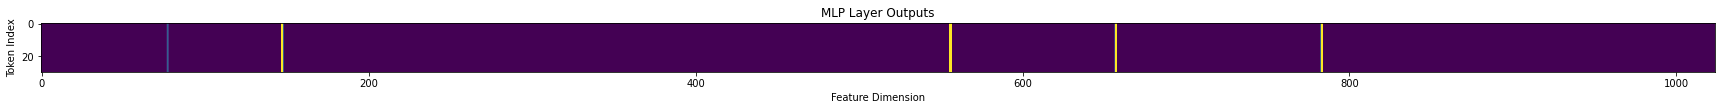

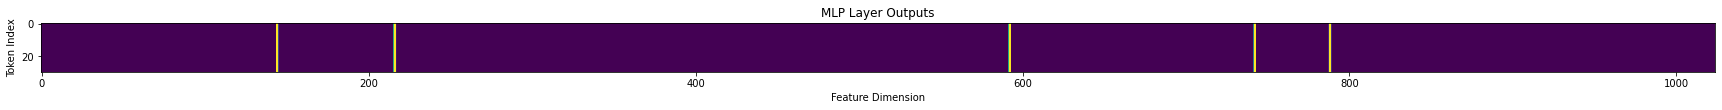

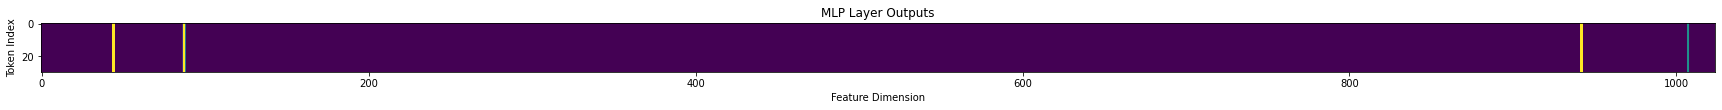

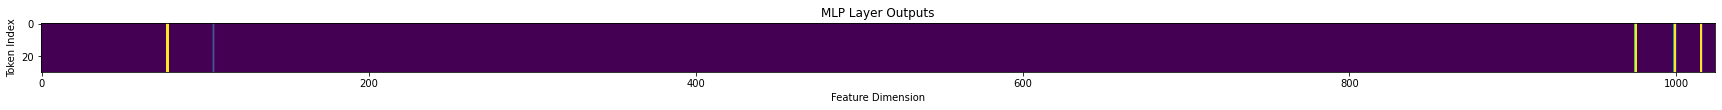

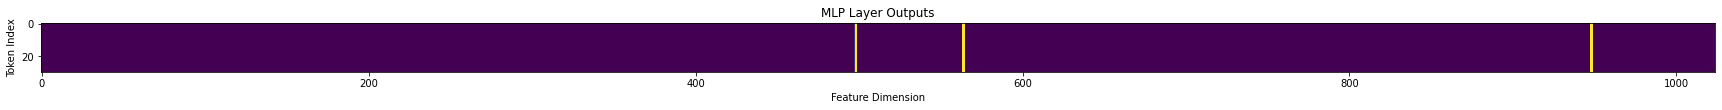

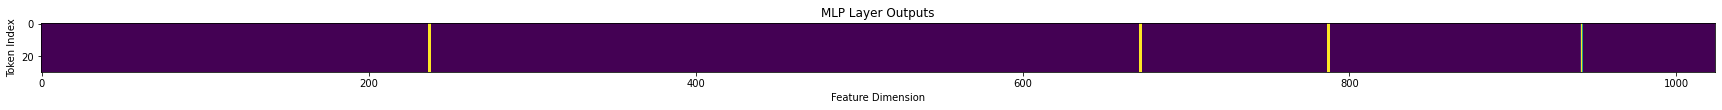

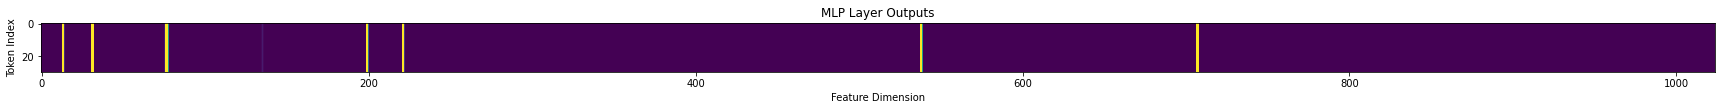

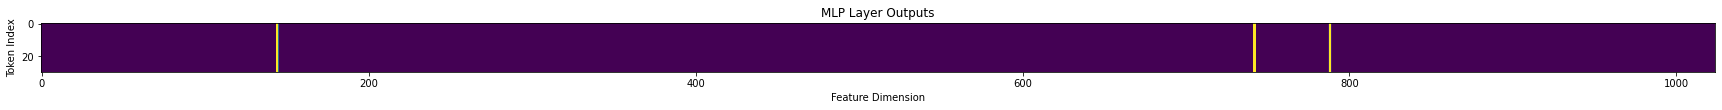

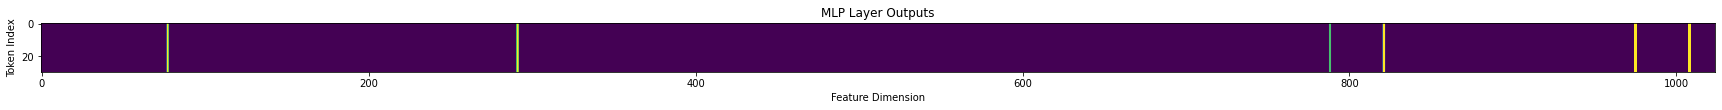

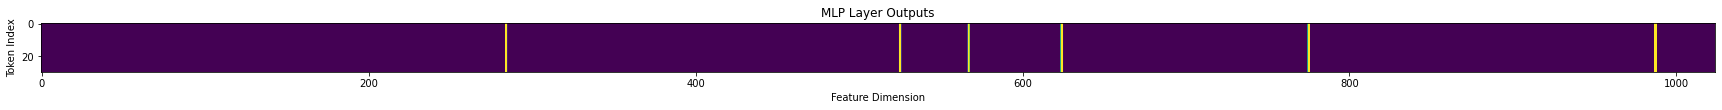

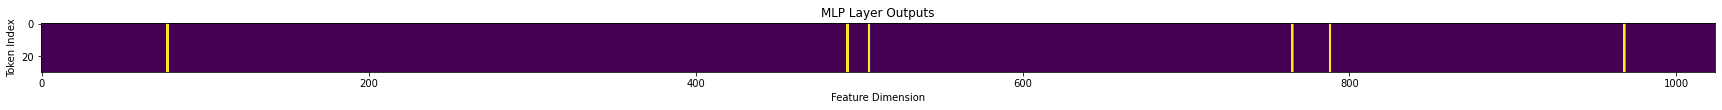

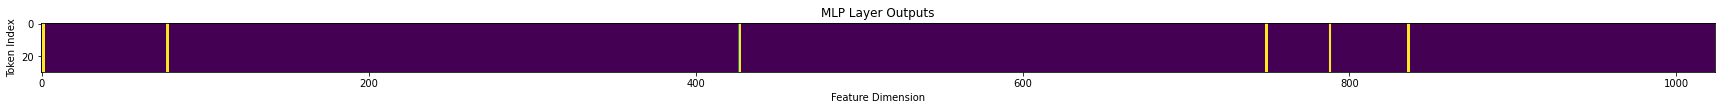

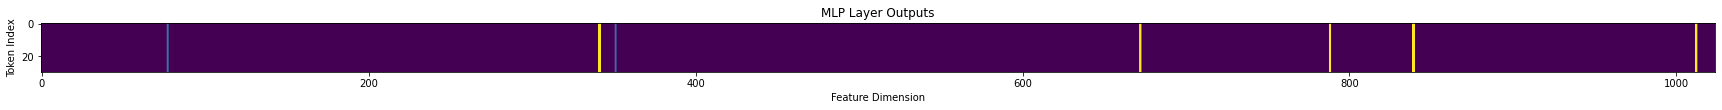

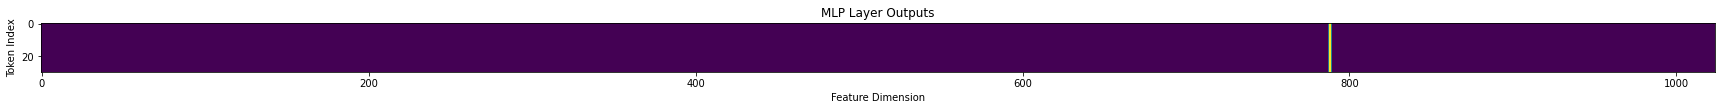

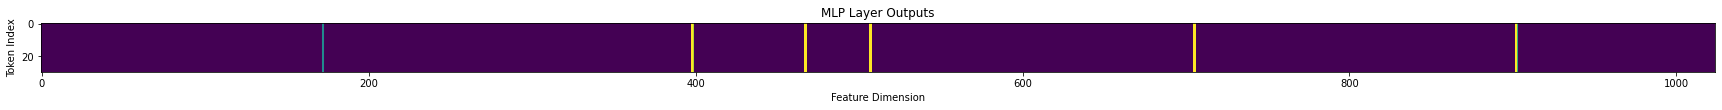

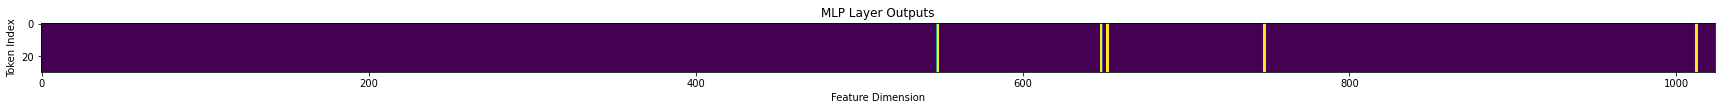

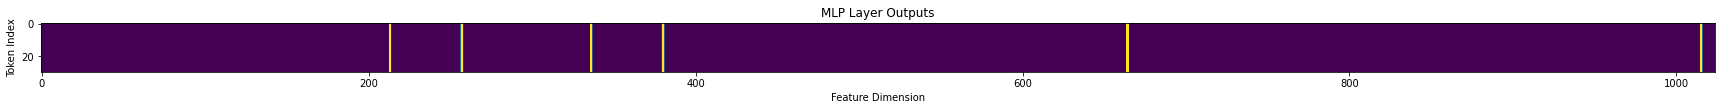

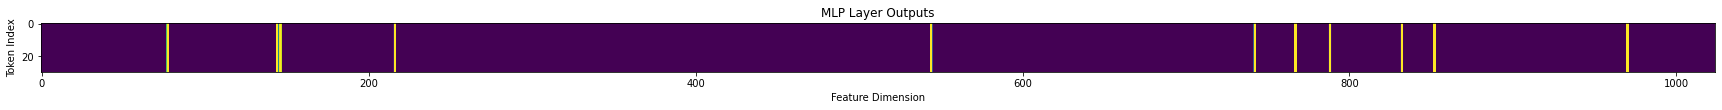

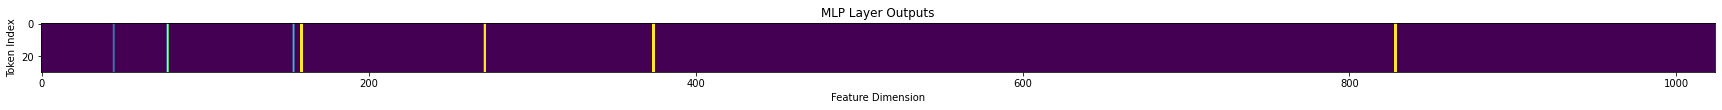

In [13]:
for act in hidden_activation:
    for i in range(1):
        plot_activation(act[:, 1024*i:1024*(i+1)].repeat(30, 1))